# Analying Amazon Review Data in Electronics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import gzip
import json

In [2]:
# Functions for reading in the dataset obtained from https://nijianmo.github.io/amazon/index.html
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [4]:
df = getDF('reviews_Electronics_5.json.gz')

In [5]:
df_backup = df.copy(deep=False)
df = df.iloc[:10000,:]

I was having memory issues using the size of the orignal dataframe

In [6]:
df = df[['reviewText', 'overall']]

## EDA

In [7]:
df.sample(5)

,reviewText,overall
2410,"I haven't really tried this yet, it hangs in m...",4.0
3920,I bought these after Shure jacked up the price...,4.0
3212,Flexibility comes at a cost in performance and...,4.0
9085,This reader works perfectly with my home-built...,5.0
2966,Diamond/S3 has created a MAJOR dud w/ this pro...,1.0


In [8]:
df.overall.value_counts()

5.0    6061
4.0    2095
3.0     822
1.0     572
2.0     450
Name: overall, dtype: int64

**Feature Descriptions**
- reviewerID – ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin – ID of the product, e.g. 0000013714
- reviewerName – name of the reviewer
- helpful – helpfulness rating of the review, e.g. 2/3
- reviewText – text of the review
- overall – rating of the product
- summary – summary of the review
- unixReviewTime – time of the review (unix time)
- reviewTime – time of the review (raw)

One of the first things that I noticed is that the 'helpful' feature will need to be massaged because it is currently in the form of a tuple.

In [6]:
def helpful_decomposition(df): 
    """This function extracts information out of the tuple 'helpful' 
    feature so that we can start to create some other features"""
    
    df['helpful_votes'] = df.helpful.apply(lambda x: x[0])
    df['overall_votes'] = df.helpful.apply(lambda x: x[1])
    df['percent_helpful'] = round((df['helpful_votes'] / df['overall_votes']) * 100)
    df['review_helpful'] = np.where((df.percent_helpful > 60) & (df.overall_votes > 5), 1, 0)

In [7]:
# Calling function to decompose the 'helpful' feature
helpful_decomposition(df)
# The dataframe now has some new features that make the 'helpful' columns more meaningful

In [8]:
df.shape

(1689188, 13)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689188 entries, 0 to 1689187
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   reviewerID       1689188 non-null  object 
 1   asin             1689188 non-null  object 
 2   reviewerName     1664458 non-null  object 
 3   helpful          1689188 non-null  object 
 4   reviewText       1689188 non-null  object 
 5   overall          1689188 non-null  float64
 6   summary          1689188 non-null  object 
 7   unixReviewTime   1689188 non-null  int64  
 8   reviewTime       1689188 non-null  object 
 9   helpful_votes    1689188 non-null  int64  
 10  overall_votes    1689188 non-null  int64  
 11  percent_helpful  725961 non-null   float64
 12  review_helpful   1689188 non-null  int32  
dtypes: float64(2), int32(1), int64(3), object(7)
memory usage: 174.0+ MB


In [10]:
df.describe()

,overall,unixReviewTime,helpful_votes,overall_votes,percent_helpful,review_helpful
count,1.689188e+06,1.689188e+06,1.689188e+06,1.689188e+06,725961.000000,1.689188e+06
mean,4.222779e+00,1.340571e+09,3.160563e+00,3.780423e+00,74.902496,8.455838e-02
std,1.185632e+00,6.342451e+07,3.896195e+01,4.067347e+01,35.223544,2.782235e-01
min,1.000000e+00,9.292320e+08,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,4.000000e+00,1.318118e+09,0.000000e+00,0.000000e+00,50.000000,0.000000e+00
50%,5.000000e+00,1.360800e+09,0.000000e+00,0.000000e+00,100.000000,0.000000e+00
75%,5.000000e+00,1.385078e+09,1.000000e+00,2.000000e+00,100.000000,0.000000e+00
max,5.000000e+00,1.406074e+09,3.073500e+04,3.145300e+04,100.000000,1.000000e+00


## EDA

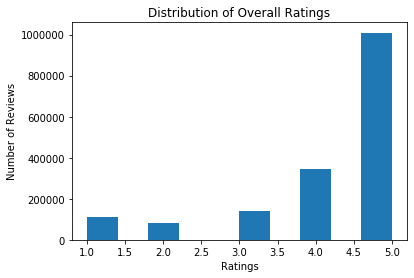

In [11]:
# Plotting distribution of overall ratings
_ = plt.hist(df.overall)
_ = plt.title('Distribution of Overall Ratings')
_ = plt.ylabel('Number of Reviews')
_ = plt.xlabel('Ratings')
# _ = plt.savefig('1.Histogram_Overall_Rating.png', dpi=900, bbox_inches='tight')

C:\Users\ZachP\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\ZachP\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


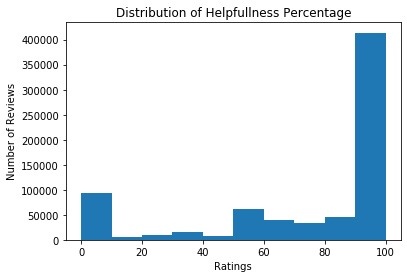

In [12]:
# Plotting distribution of helpfullness percentage
_ = plt.hist(df.percent_helpful)
_ = plt.title('Distribution of Helpfullness Percentage')
_ = plt.ylabel('Number of Reviews')
_ = plt.xlabel('Ratings')
# _ = plt.savefig('1.Histogram_Helpfullness_Percentage.png', dpi=900, bbox_inches='tight')

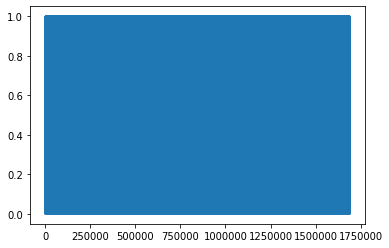

In [14]:
_ = plt.plot(df.review_helpful)

## Testing NLP with SKLearn

In [9]:
import preprocess_kgptalkie as ps
import re

In [10]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [11]:
df.reviewText = df.reviewText.apply(lambda x: get_clean(x))

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [13]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,3), analyzer='char')

In [14]:
X = tfidf.fit_transform(df.reviewText)
y = df.overall

In [17]:
X.shape, y.shape

((10000, 14598), (10000,))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [19]:
X_train.shape

(8000, 14598)

In [35]:
clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [36]:
y_pred = clf.predict(X_test)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.62      0.20      0.31       113
         2.0       0.33      0.01      0.02       100
         3.0       0.18      0.02      0.04       187
         4.0       0.36      0.16      0.22       407
         5.0       0.65      0.96      0.77      1193

    accuracy                           0.62      2000
   macro avg       0.43      0.27      0.27      2000
weighted avg       0.53      0.62      0.53      2000



- Initial model is 53% accurate
- 2, 3 and 4 star reviews have low accuracy
- I will optimize hyper-paramters in the classifier

One idea that I came across is to adjust the C parameter and class_weight parameter, which will try to balance the overall accruacy.

In [42]:
clf = LinearSVC(C=20, class_weight='balanced')
clf.fit(X_train, y_train)

LinearSVC(C=20, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [43]:
y_pred = clf.predict(X_test)

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.40      0.38      0.39       113
         2.0       0.20      0.18      0.19       100
         3.0       0.22      0.24      0.23       187
         4.0       0.31      0.32      0.31       407
         5.0       0.74      0.73      0.74      1193

    accuracy                           0.56      2000
   macro avg       0.37      0.37      0.37      2000
weighted avg       0.56      0.56      0.56      2000



f1 score improved

In [49]:
# Testing it with real data
x = 'this prodcut is reall bad. i do not like it'
x = get_clean(x)
vec = tfidf.transform([x])
clf.predict(vec)

array([2.])

In [50]:
# Model is predictinga 2 star rating

In [51]:
# Testing it with real data
x = 'this prodcut is really good. thanks a lot fot the speedy delviery'
x = get_clean(x)
vec = tfidf.transform([x])
clf.predict(vec)

array([5.])

In [52]:
# Model is predictinga 5 star rating